## Xây dựng dữ liệu

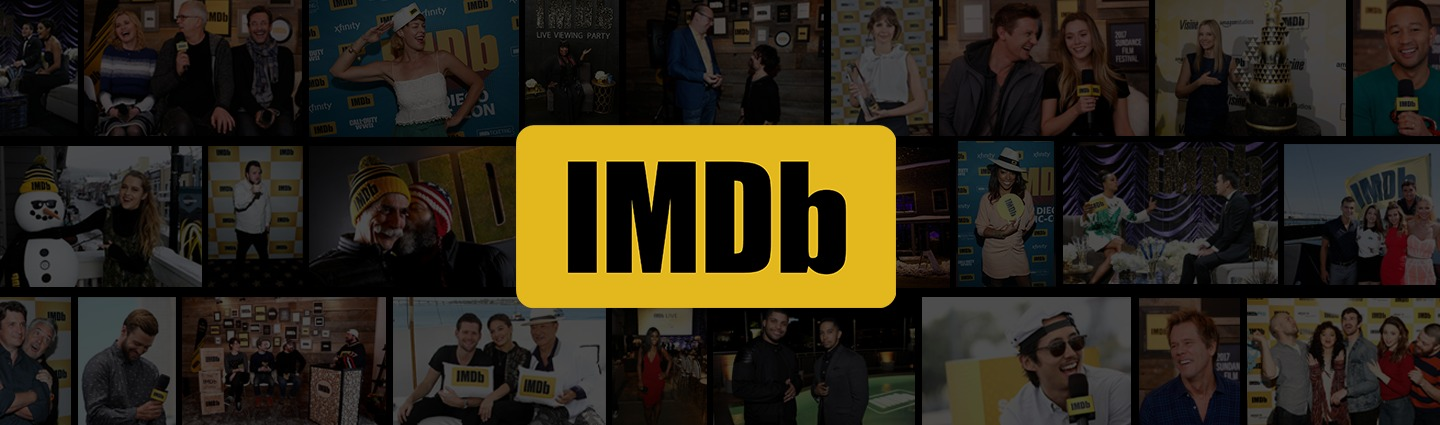

Trong bài tập này, các bạn sẽ cài đặt và so sánh các biến thể của mạng RNN cho bài toán phân loại văn bản trên tập dữ liệu đánh giá phim của IMDB để phân tích sắc thái của người xem.

**Lưu ý:** phiên bản của thư viện tensorflow là 2.18.0

In [1]:
!pip install tensorflow_datasets
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf

import random

def fix_random_seed():
  random.seed(10)
  np.random.seed(10)
  tf.random.set_seed(10)

In [2]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Bộ dữ liệu đánh giá phim của IMDB là bộ dữ liệu phân loại nhị phân — tất cả các đánh giá đều có ý kiến ​​tích cực hoặc tiêu cực.

In [3]:
fix_random_seed()
# Tải tập dữ liệu IMDB Reviews
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True, split=['train', 'test[:12500]','test[12500:]'])
TRAIN_DATASET, VAL_DATASET, TEST_DATASET = dataset

# Hàm tách dữ liệu theo nhãn
def filter_by_label(dataset, label):
    return dataset.filter(lambda text, lbl: lbl == label)

# Tách dữ liệu huấn luyện theo nhãn
train_pos = filter_by_label(TRAIN_DATASET, 1)
train_neg = filter_by_label(TRAIN_DATASET, 0)

# Tách dữ liệu kiểm tra theo nhãn
test_pos = filter_by_label(TEST_DATASET, 1)
test_neg = filter_by_label(TEST_DATASET, 0)

# Tách dữ liệu xác thực theo nhãn
val_pos = filter_by_label(VAL_DATASET, 1)
val_neg = filter_by_label(VAL_DATASET, 0)


# Số lượng mẫu cần lấy cho mỗi nhãn
num_train_samples_per_class = 1000
num_val_samples_per_class = 500
num_test_samples_per_class = 500

# Lấy mẫu ngẫu nhiên và kết hợp cho tập huấn luyện
train_pos_sample = train_pos.take(num_train_samples_per_class)
train_neg_sample = train_neg.take(num_train_samples_per_class)
balanced_train_dataset = train_pos_sample.concatenate(train_neg_sample)

# Lấy mẫu ngẫu nhiên và kết hợp cho tập kiểm tra
test_pos_sample = test_pos.take(num_test_samples_per_class)
test_neg_sample = test_neg.take(num_test_samples_per_class)
balanced_test_dataset = test_pos_sample.concatenate(test_neg_sample)

# Lấy mẫu ngẫu nhiên và kết hợp cho tập xác thực
val_pos_sample = val_pos.take(num_val_samples_per_class)
val_neg_sample = val_neg.take(num_val_samples_per_class)
balanced_val_dataset = val_pos_sample.concatenate(val_neg_sample)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.C14AN3_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.C14AN3_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.C14AN3_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
for example, label in balanced_train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.'
label:  1


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
def generate_data_pipeline():
  train_dataset = balanced_train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)
  test_dataset = balanced_test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  val_dataset = balanced_val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  return train_dataset, test_dataset, val_dataset

Văn bản thô trong bộ dữ  cần được xử lý trước khi có thể sử dụng trong mô hình. Cách đơn giản nhất để xử lý văn bản để đào tạo là sử dụng lớp TextVectorization

In [6]:
TRAIN_DATASET_V = TRAIN_DATASET.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
#Tạo lớp encoder và truyền văn bản của tập dữ liệu qua phương thức .adapt:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(TRAIN_DATASET_V.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())

# 20 token đầu tiên dựa trên tần suất xuất hiện của chúng trong bộ dữ
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [7]:
# Văn bản sau khi xử lý sẽ ở dạng các vector số.
encoded_example = encoder(example).numpy()
encoded_example

array([ 11,   7,   2, 238,   5,  20,  16,   4,   1,   1,   1,  51,   2,
       343,   5,   2, 188,  69, 138,   1,  17,  30, 200, 978,  15,  23,
         1,  78,   4, 196,   1,   3,   1,  16,   4, 365,   5, 612, 374,
       347,  36,   1,   3,   1,   1,  15, 203,   1,   1,   2, 114, 354,
        48,  24,  57,   1,   6,   1,  57,   1,   1,  41,   4,   1,   3,
         1,   1, 141, 155, 769, 119,  31,  30, 115,   4, 222,  20,   8,
       168, 278,   3,  29,  12, 985,   2,   1,   9,   1])

## Cài đặt RNN

RNN (Recurrent Neural Network) là một loại mạng nơ-ron nhân tạo được thiết kế để xử lý dữ liệu tuần tự, nơi mà thông tin đầu vào có phụ thuộc theo thời gian hoặc theo thứ tự. Đây là một kiến trúc mạng rất phổ biến trong các bài toán xử lý ngôn ngữ tự nhiên (NLP), nhận dạng giọng nói, phân tích chuỗi thời gian, v.v.

Khác với các mạng feedforward như MLP (Multi-layer Perceptron), RNN có một đặc điểm chính là tái sử dụng cùng một tập trọng số cho mỗi bước thời gian và duy trì một trạng thái ẩn (hidden state), cho phép mô hình lưu giữ thông tin từ các bước trước đó trong chuỗi.

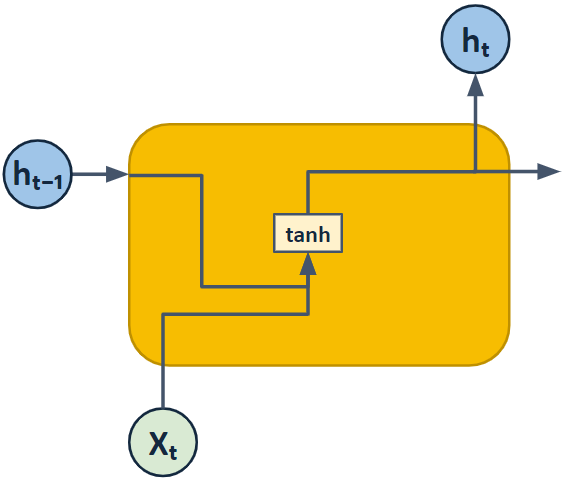

Dưới đây là sơ đồ xây dựng một mạng RNN đơn giản cho bài toán phân loại văn bản

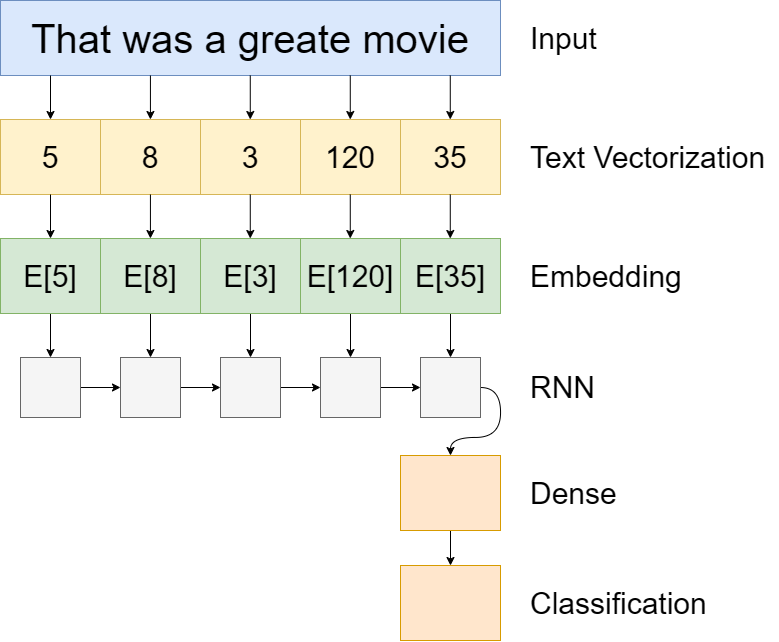

In [8]:
fix_random_seed()
# Xây dựng một mô hình RNN đơn giản
model_RNN = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Sử dụng mask để xử lý độ dài chuỗi thay đổi
        mask_zero=True),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
model_RNN.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [10]:
train_dataset,test_dataset,val_dataset = generate_data_pipeline()
history = model_RNN.fit(train_dataset,
epochs=20,
steps_per_epoch=len(list(balanced_train_dataset))//BATCH_SIZE,
validation_data=val_dataset,
validation_steps=len(list(balanced_val_dataset))//BATCH_SIZE)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 440ms/step - accuracy: 0.5057 - loss: 0.6944 - val_accuracy: 0.4833 - val_loss: 0.6965
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 424ms/step - accuracy: 0.5553 - loss: 0.6888 - val_accuracy: 0.4802 - val_loss: 0.6967
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 644ms/step - accuracy: 0.5911 - loss: 0.6829 - val_accuracy: 0.4948 - val_loss: 0.6958
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 672ms/step - accuracy: 0.6585 - loss: 0.6713 - val_accuracy: 0.4917 - val_loss: 0.6963
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 691ms/step - accuracy: 0.7043 - loss: 0.6610 - val_accuracy: 0.4948 - val_loss: 0.6967
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 410ms/step - accuracy: 0.6985 - loss: 0.6540 - val_accuracy: 0.5115 - val_loss: 0.6969
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 650ms/step - accuracy: 0.7507 - loss: 0.6386 - val_accuracy: 0.5135 - val_loss: 0.6993
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 673ms/step - accuracy: 0.7547 - loss: 0.6188 - val_accu

In [11]:
test_loss, test_acc = model_RNN.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.4466 - loss: 1.0349
Test Loss: 0.9494317770004272
Test Accuracy: 0.49900001287460327


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


(0.0, 0.9580604366958141)

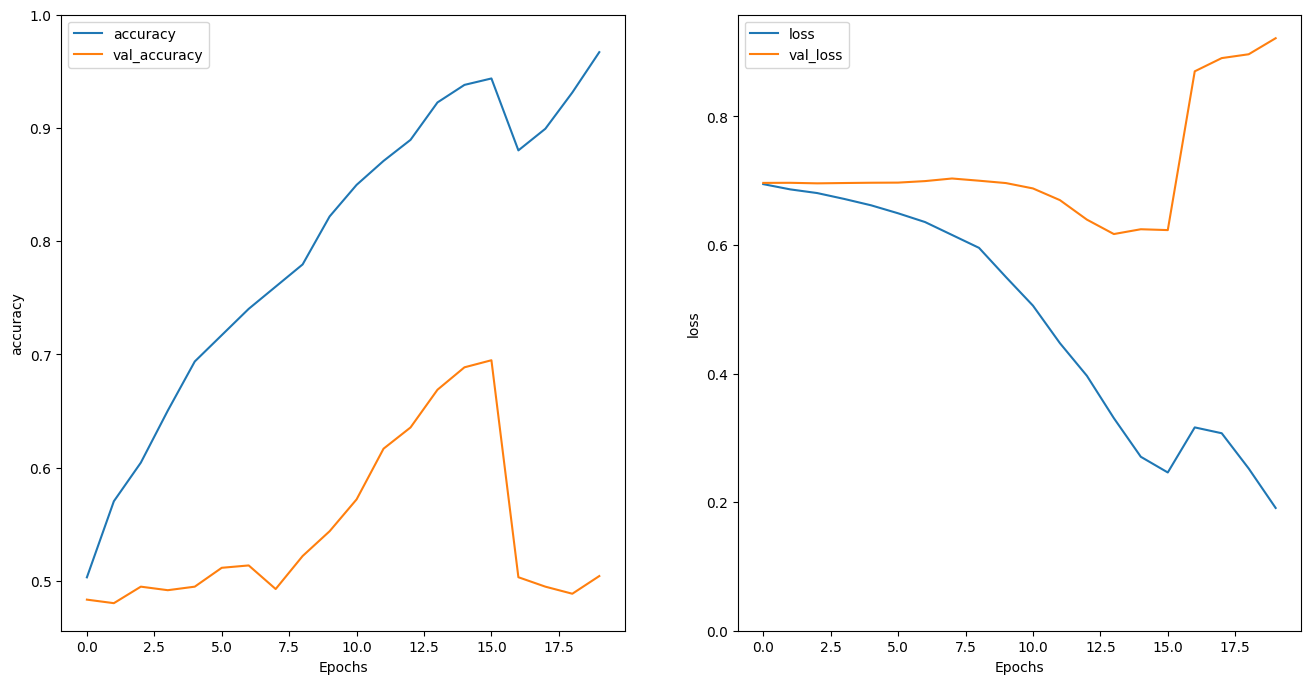

In [12]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

# Task 1: Cài đặt LSTM
Trong RNN, khi chuỗi trở nên dài, các gradient trong quá trình lan truyền ngược sẽ bị tiêu biến hoặc bùng nổ, khiến mô hình không học được các mối quan hệ xa (long-term dependencies). LSTM khắc phục điều đó bằng cách sử dụng các cổng (gates) để kiểm soát thông tin nào được ghi nhớ, cập nhật hoặc quên.

Một cell LSTM bao gồm 3 cổng chính và một trạng thái bộ nhớ (cell state):

* Cell state ($c_t$): giống như “băng chuyền thông tin”, truyền thông tin qua các bước thời gian với ít sự thay đổi

* Hidden state ($h_t$): đầu ra tại mỗi bước, đồng thời cũng được đưa về sau như trạng thái ẩn.

* Forget gate: quyết định thông tin nào sẽ bị quên khỏi $c_t$

* Input gate: quyết định thông tin mới nào sẽ được lưu vào $c_t$

* Output gate: quyết định phần nào của $c_t$ được dùng để tạo $h_t$


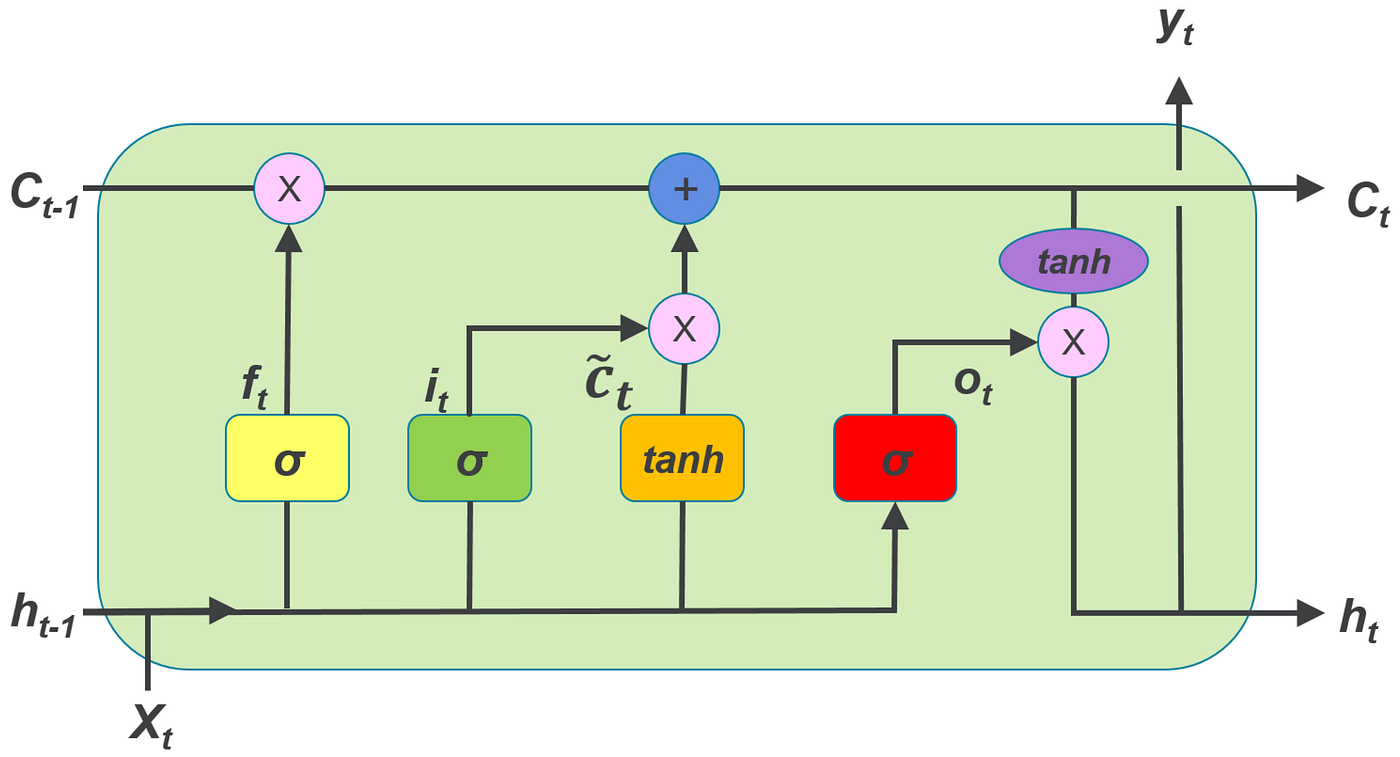

Hãy xây dựng mô hình phân loại văn bản dựa trên LSTM với các thành phần:
*   1 lớp encoder
*   1 lớp embedding với kích thước đầu ra là 64
*   1 lớp LSTM với kích thước đầu ra là 64 (Tham khảo trong [tf.keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers))

*   1 lớp Dense với kích thước đầu ra là 64, sử dụng activation là relu
*   1 lớp Dense (Output) với với kích thước đầu ra là 1, sử dụng activation là sigmoid

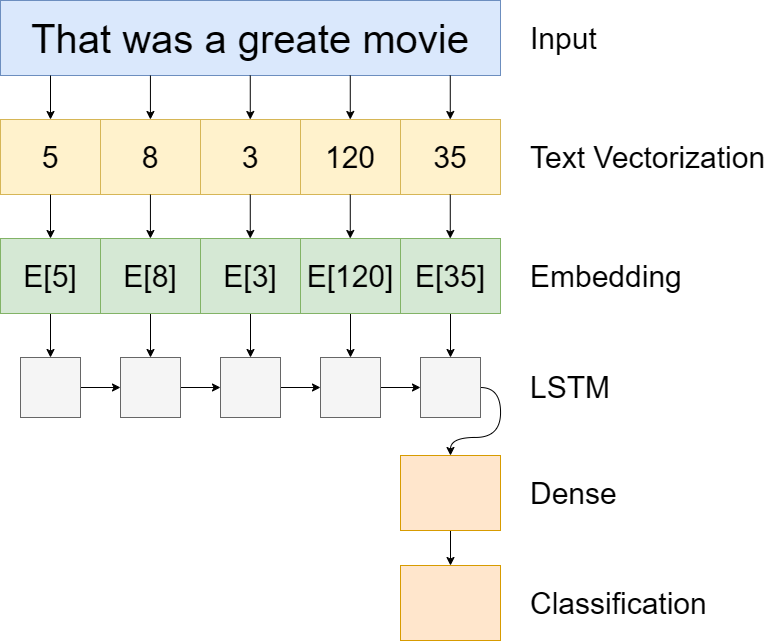



In [13]:
fix_random_seed()
model_LSTM = tf.keras.Sequential([
### BEGIN SOLUTION
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Sử dụng mask để xử lý độ dài chuỗi thay đổi
        mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
### END SOLUTION
])
model_LSTM.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [14]:
train_dataset,test_dataset,val_dataset = generate_data_pipeline()
history = model_LSTM.fit(train_dataset,
epochs=20,
steps_per_epoch=len(list(balanced_train_dataset))//BATCH_SIZE,
validation_data=val_dataset,
validation_steps=len(list(balanced_val_dataset))//BATCH_SIZE)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 839ms/step - accuracy: 0.5097 - loss: 0.6932 - val_accuracy: 0.4958 - val_loss: 0.6932
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5239 - loss: 0.6928 - val_accuracy: 0.5250 - val_loss: 0.6929
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5844 - loss: 0.6924 - val_accuracy: 0.5458 - val_loss: 0.6927
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6363 - loss: 0.6915 - val_accuracy: 0.5521 - val_loss: 0.6920
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 834ms/step - accuracy: 0.6251 - loss: 0.6905 - val_accuracy: 0.5781 - val_loss: 0.6908
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6358 - loss: 0.6886 - val_accuracy: 0.5938 - val_loss: 0.6882
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 825ms/step - accuracy: 0.6543 - loss: 0.6818 - val_accuracy: 0.6469 - val_loss: 0.6744
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7055 - loss: 0.6484 - val_accuracy: 0.6885 - 

In [15]:
test_loss, test_acc = model_LSTM.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.8302 - loss: 0.3584
Test Loss: 0.412544846534729
Test Accuracy: 0.8180000185966492


(0.0, 0.7396498993039131)

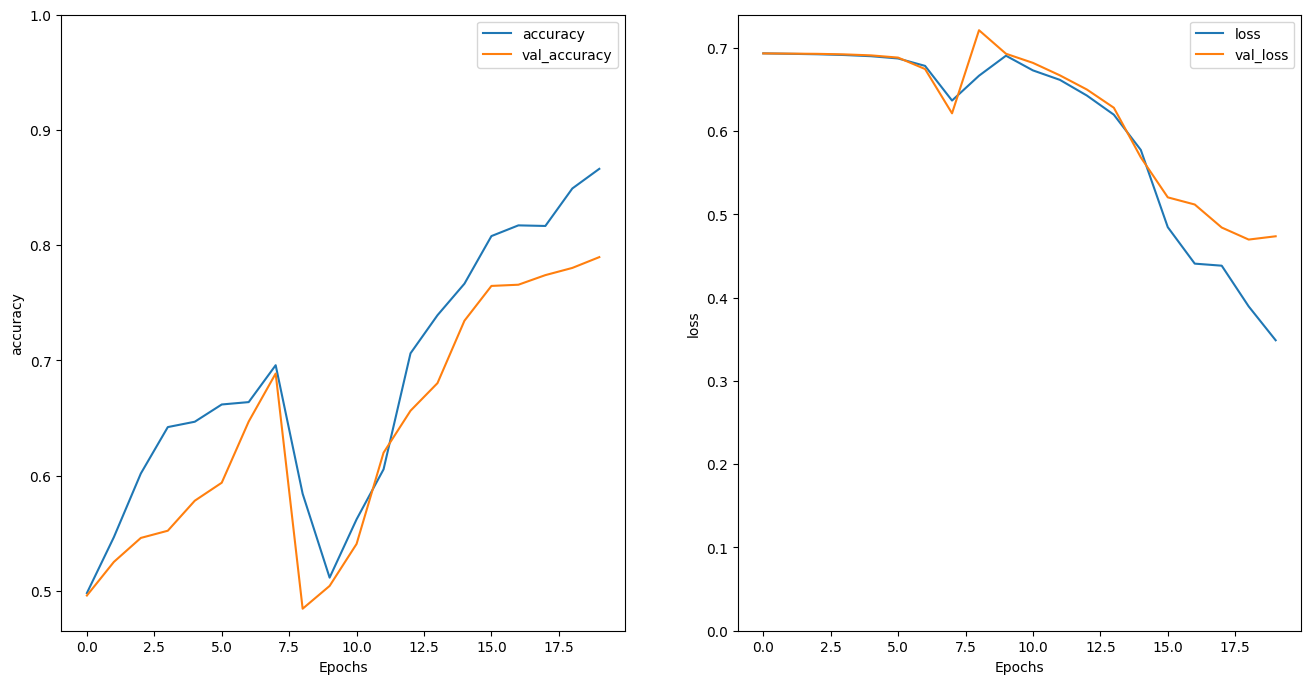

In [16]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Theo bạn giữa phiên bản RNN và LSTM, bạn thấy độ chính xác trên tập test có sự thay đổi đáng kể hay không?

In [17]:
options = ['Không có ý kiến', 'RNN tốt hơn LSTM', 'RNN tệ hơn LSTM', 'RNN ngang ngửa LSTM (chênh không quá 1%)']

your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
### BEGIN SOLUTION
your_choice = 2
### END SOLUTION

print("Theo tôi thì: ", options[your_choice])

Theo tôi thì:  Không có ý kiến


Theo bạn giữa phiên bản RNN và LSTM, bạn thấy tốc độ huấn luyện có sự thay đổi đáng kể hay không?

In [18]:
options = ['Không có ý kiến', 'RNN train nhanh hơn LSTM', 'RNN train chậm hơn LSTM', 'RNN ngang ngửa LSTM)']

your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
### BEGIN SOLUTION
your_choice = 1
### END SOLUTION

print("Theo tôi thì: ", options[your_choice])

Theo tôi thì:  Không có ý kiến


# Task 2: Cài đặt Bidirectional RNN
Bidirectional RNN (RNN hai chiều) là một kỹ thuật mở rộng mạng RNN/LSTM/GRU để xử lý thông tin theo cả hai chiều thời gian: từ quá khứ → tương lai và từ tương lai → quá khứ.

Hãy xây dựng mô hình phân loại văn bản dựa trên Bidirectional RNN với các thành phần:
*   1 lớp encoder
*   1 lớp embedding với kích thước đầu ra là 64
*   1 lớp Bidirectional RNN với kích thước đầu ra là 64 (Tham khảo [Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional))
*   1 lớp Dense với kích thước đầu ra là 64, sử dụng activation là relu
*   1 lớp Dense (Output) với kích thước đầu ra là 1, sử dụng activation là sigmoid

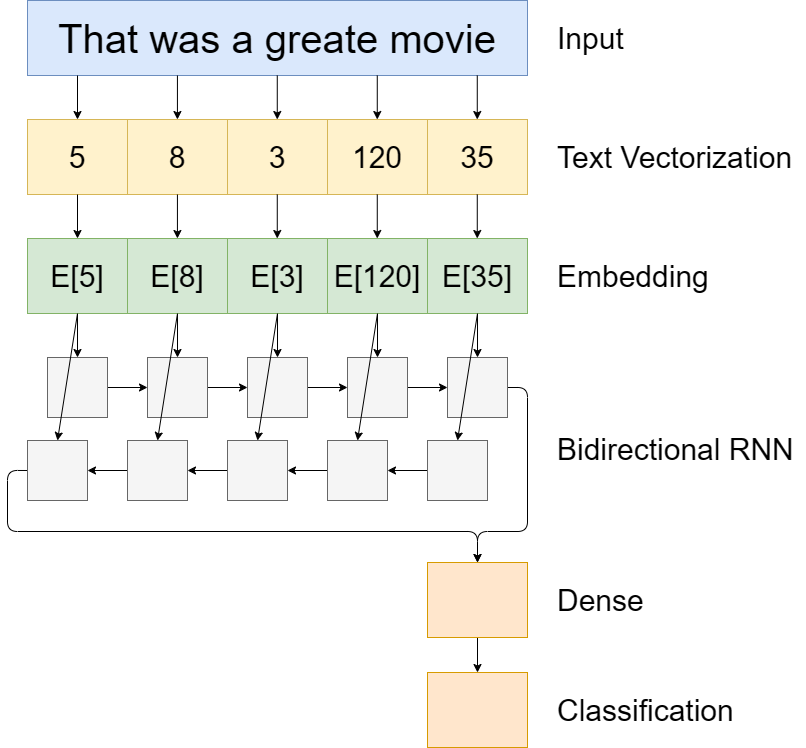

In [20]:
fix_random_seed()
model_BiRNN = tf.keras.Sequential([
### BEGIN SOLUTION
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Sử dụng mask để xử lý độ dài chuỗi thay đổi
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
### END SOLUTION
])
model_BiRNN.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
train_dataset,test_dataset,val_dataset = generate_data_pipeline()
history = model_BiRNN.fit(train_dataset,
epochs=20,
steps_per_epoch=len(list(balanced_train_dataset))//BATCH_SIZE,
validation_data=val_dataset,
validation_steps=len(list(balanced_val_dataset))//BATCH_SIZE)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 32s 845ms/step - accuracy: 0.4954 - loss: 0.6962 - val_accuracy: 0.5385 - val_loss: 0.6903
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 860ms/step - accuracy: 0.5778 - loss: 0.6829 - val_accuracy: 0.5406 - val_loss: 0.6902
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6325 - loss: 0.6738 - val_accuracy: 0.5875 - val_loss: 0.6840
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6494 - loss: 0.6617 - val_accuracy: 0.6177 - val_loss: 0.6734
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 821ms/step - accuracy: 0.6973 - loss: 0.6373 - val_accuracy: 0.6083 - val_loss: 0.6617
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7363 - loss: 0.5970 - val_accuracy: 0.6229 - val_loss: 0.6567
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 867ms/step - accuracy: 0.6815 - loss: 0.6017 - val_accuracy: 0.6635 - val_loss: 0.6199
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7804 - loss: 0.5329 - val_accuracy: 0.6938

In [22]:
test_loss, test_acc = model_BiRNN.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.8124 - loss: 0.5124
Test Loss: 0.5681598782539368
Test Accuracy: 0.7919999957084656


(0.0, 0.7229231834411621)

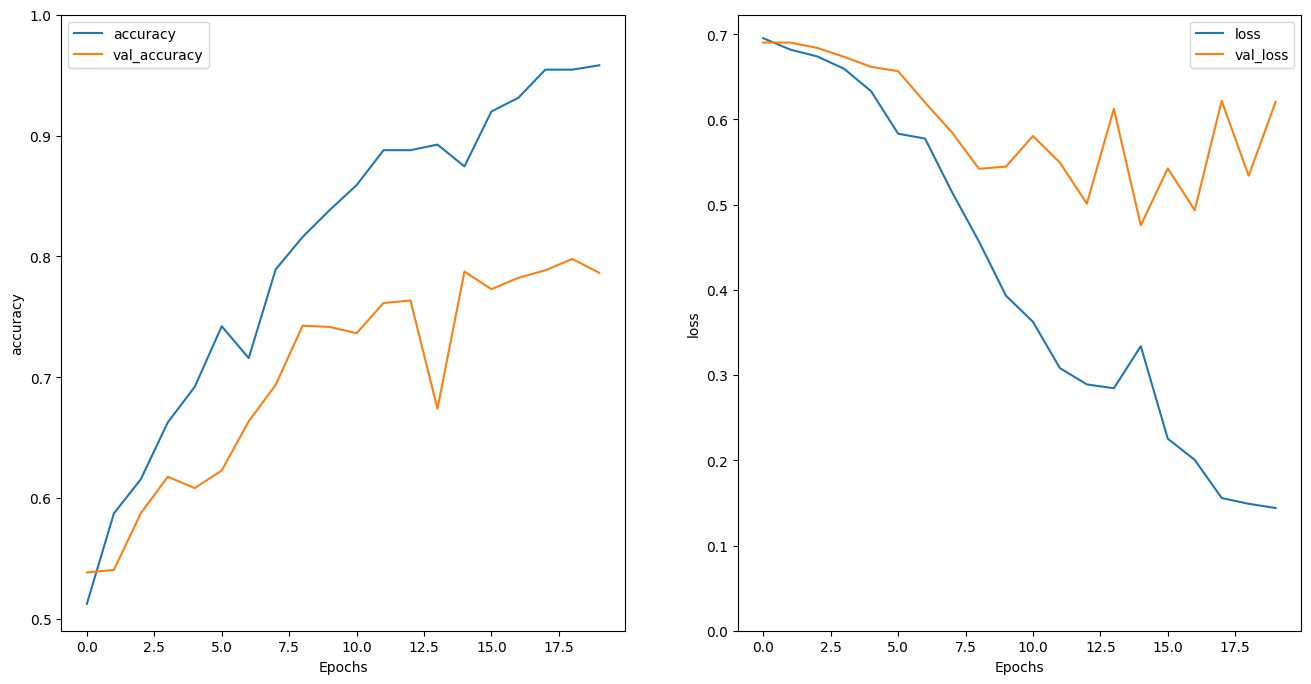

In [23]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Theo bạn giữa phiên bản RNN và Bidirectional RNN, bạn thấy độ chính xác trên tập test có sự thay đổi đáng kể hay không?

In [24]:
options = ['Không có ý kiến',
           'RNN tốt hơn Bidirectional RNN',
           'RNN tệ hơn Bidirectional RNN',
           'RNN ngang ngửa Bidirectional RNN (chênh không quá 1%)']

your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
### BEGIN SOLUTION
your_choice = 2
### END SOLUTION

print("Theo tôi thì: ", options[your_choice])

Theo tôi thì:  Không có ý kiến


Theo bạn giữa phiên bản RNN và Bidirectional RNN, bạn thấy tốc độ huấn luyện có sự thay đổi đáng kể hay không?

In [25]:
options = ['Không có ý kiến',
           'RNN train nhanh hơn Bidirectional RNN',
           'RNN train chậm hơn Bidirectional RNN',
           'RNN ngang ngửa Bidirectional RNN)']

your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
### BEGIN SOLUTION
your_choice = 1
### END SOLUTION

print("Theo tôi thì: ", options[your_choice])

Theo tôi thì:  Không có ý kiến


# Task 3: Cài đặt Deep Stacked RNN
"Deep" ở đây đề cập đến việc xếp chồng nhiều lớp RNN lên nhau. Việc này tạo ra một mạng nơ-ron sâu, cho phép mô hình học được các biểu diễn phức tạp hơn của dữ liệu. Việc xếp chồng các lớp RNN giúp tăng khả năng biểu diễn của mô hình, cho phép nó nắm bắt các mẫu và mối quan hệ phức tạp hơn trong dữ liệu tuần tự.

Hãy xây dựng mô hình phân loại văn bản dựa trên Deep Stacked RNN với các thành phần:
*   1 lớp encoder
*   1 lớp embedding với kích thước đầu ra là 64
*   1 lớp RNN với kích thước đầu ra là 64 (lưu ý: cần set return_sequences=True)
*   1 lớp RNN với kích thước đầu ra là 32
*   1 lớp Dense với kích thước đầu ra là 64, sử dụng activation là relu
*   1 lớp Dense (Output) với kích thước đầu ra là 1, sử dụng activation là sigmoid

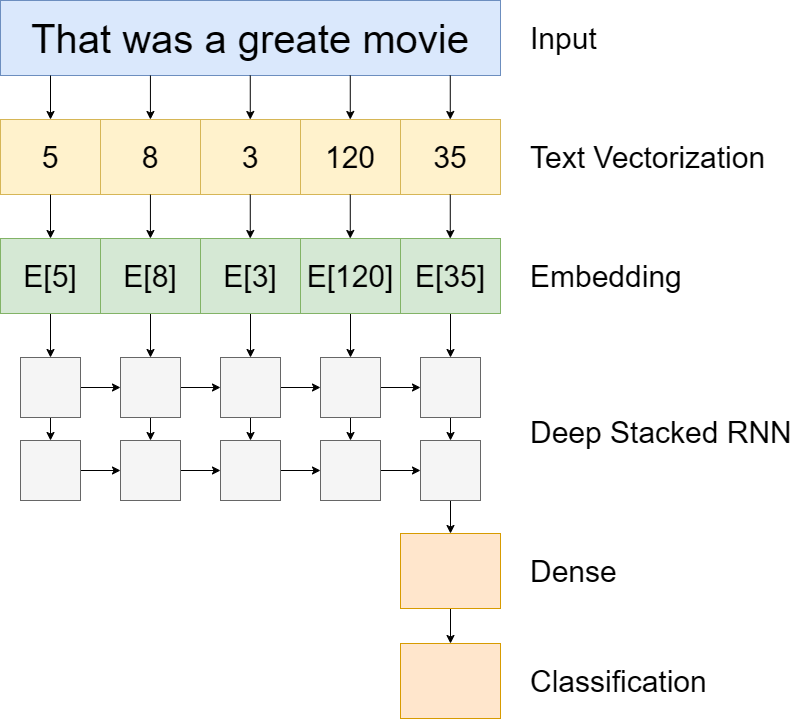


In [26]:
fix_random_seed()
model_DeepRNN = tf.keras.Sequential([
### BEGIN SOLUTION
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Sử dụng mask để xử lý độ dài chuỗi thay đổi
        mask_zero=True),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
### END SOLUTION
])
model_DeepRNN.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
train_dataset,test_dataset,val_dataset = generate_data_pipeline()
history = model_DeepRNN.fit(train_dataset,
epochs=20,
steps_per_epoch=len(list(balanced_train_dataset))//BATCH_SIZE,
validation_data=val_dataset,
validation_steps=len(list(balanced_val_dataset))//BATCH_SIZE)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 32s 862ms/step - accuracy: 0.4889 - loss: 0.7091 - val_accuracy: 0.5188 - val_loss: 0.6949
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 831ms/step - accuracy: 0.5477 - loss: 0.6879 - val_accuracy: 0.5031 - val_loss: 0.6966
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5679 - loss: 0.6752 - val_accuracy: 0.4958 - val_loss: 0.6998
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 820ms/step - accuracy: 0.6232 - loss: 0.6555 - val_accuracy: 0.5031 - val_loss: 0.7022
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6405 - loss: 0.6478 - val_accuracy: 0.4969 - val_loss: 0.7079
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6961 - loss: 0.6233 - val_accuracy: 0.5000 - val_loss: 0.7109
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7433 - loss: 0.5968 - val_accuracy: 0.4885 - val_loss: 0.7221
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 875ms/step - accuracy: 0.7782 - loss: 0.5634 - val_accuracy: 0.4958

In [ ]:
test_loss, test_acc = model_DeepRNN.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Theo bạn giữa phiên bản LSTM và DeepStacked RNN, bạn thấy độ chính xác trên tập test có sự thay đổi đáng kể hay không?

In [ ]:
options = ['Không có ý kiến',
           'LSTM tốt hơn DeepStacked RNN',
           'LSTM tệ hơn DeepStacked RNN',
           'LSTM ngang ngửa DeepStacked RNN (chênh không quá 1%)']

your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
### BEGIN SOLUTION
your_choice = 1
### END SOLUTION

print("Theo tôi thì: ", options[your_choice])

Theo bạn giữa phiên bản RNN và Deep Stacked RNN, bạn thấy tốc độ huấn luyện có sự thay đổi đáng kể hay không?

In [ ]:
options = ['Không có ý kiến',
           'RNN train nhanh hơn Deep Stacked RNN',
           'RNN train chậm hơn Deep Stacked RNN',
           'RNN ngang ngửa Deep Stacked RNN']

your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
### BEGIN SOLUTION
your_choice = 1
### END SOLUTION

print("Theo tôi thì: ", options[your_choice])